<a href="https://colab.research.google.com/github/j-nat/Facial-Landmark-Detection/blob/main/VGG16_from_scratch_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import libraries

In [1]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from torch.utils.data import random_split
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#dataset data augmentation dataloader

In [2]:
BATCH_SIZE=64
num_epochs=20
learning_rate = 1e-4
class_size=10

In [3]:
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

In [4]:
tranform_train = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#prep the train, validation and test dataset
torch.manual_seed(2021)
train = torchvision.datasets.CIFAR10("data/", train=True, download=True, transform=tranform_train) 
val_size = 10000 
train_size = len(train) - val_size
train, val = random_split(train, [train_size, val_size]) 
test = torchvision.datasets.CIFAR10("data/", train=False, download=True, transform=tranform_test) 

#  train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [26]:
test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

images.shape: torch.Size([64, 3, 224, 224])


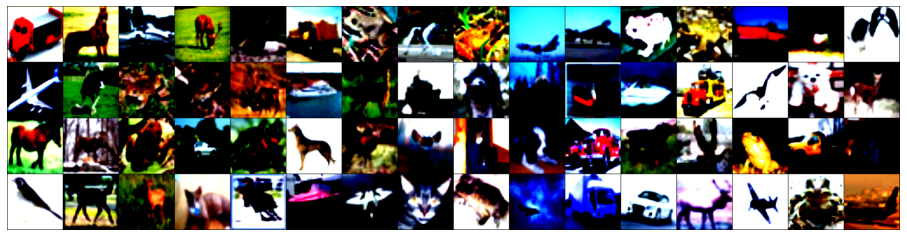

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
sample_image=iter(train_loader)
samples,labels=next(sample_image)
print(samples.shape) #64 batch size, 1 channel, width 224 , height 224
print(labels)

torch.Size([64, 3, 224, 224])
tensor([8, 2, 0, 6, 2, 5, 6, 8, 5, 5, 3, 9, 4, 8, 2, 7, 3, 0, 2, 9, 4, 2, 6, 6,
        9, 9, 6, 1, 7, 3, 6, 3, 1, 6, 5, 3, 5, 5, 5, 0, 9, 3, 8, 1, 9, 8, 7, 6,
        7, 6, 8, 1, 6, 0, 1, 8, 8, 8, 8, 0, 8, 2, 6, 6])


#model

In [7]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16_NET()
model = model.to(device=device)
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#train

In [10]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
  loss_var = 0

  for idx, (images, labels) in enumerate(train_loader):
    images = images.to(device = device)
    labels = labels.to(device = device)

    optimizer.zero_grad()
    preds = model(images)

    loss = criterion (preds, labels)
    loss.backward()
    optimizer.step()

    loss_var += loss.item()

    if idx%64 == 0:
       print(f'Epoch [{epoch+1}/{num_epochs}] || Step [{idx+1}/{len(train_loader)}] || Loss:{loss_var/len(train_loader)}')
  print(f"Loss at epoch {epoch+1} || {loss_var/len(train_loader)}")

  train_losses.append(loss_var)

  with torch.no_grad():
    samples = 0
    correct = 0
    loss_val = 0
    for idx, (images, labels) in enumerate(val_loader):
      images = images.to(device = device)
      labels = labels.to(device = device)

      outputs = model(images)

      loss = criterion (outputs, labels)
      loss_val += loss.item()

      _, preds = outputs.max(1)

      correct += (preds == labels).sum()
      samples += preds.size(0)

    print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")

    val_losses.append(loss_val)



Epoch [1/20] || Step [1/625] || Loss:0.0024374061584472658
Epoch [1/20] || Step [65/625] || Loss:0.15471420917510986
Epoch [1/20] || Step [129/625] || Loss:0.30424155864715574
Epoch [1/20] || Step [193/625] || Loss:0.4476824426651001
Epoch [1/20] || Step [257/625] || Loss:0.5857993432998657
Epoch [1/20] || Step [321/625] || Loss:0.720602686882019
Epoch [1/20] || Step [385/625] || Loss:0.852373493385315
Epoch [1/20] || Step [449/625] || Loss:0.9770609840393066
Epoch [1/20] || Step [513/625] || Loss:1.100717283821106
Epoch [1/20] || Step [577/625] || Loss:1.22209274187088
Loss at epoch 1 || 1.3095361048698426
accuracy 60.55 percentage || Correct 6055 out of 10000 samples
Epoch [2/20] || Step [1/625] || Loss:0.0019223981857299805
Epoch [2/20] || Step [65/625] || Loss:0.11317205228805542
Epoch [2/20] || Step [129/625] || Loss:0.22174052057266236
Epoch [2/20] || Step [193/625] || Loss:0.32571841974258425
Epoch [2/20] || Step [257/625] || Loss:0.429709965133667
Epoch [2/20] || Step [321/625]

KeyboardInterrupt: ignored

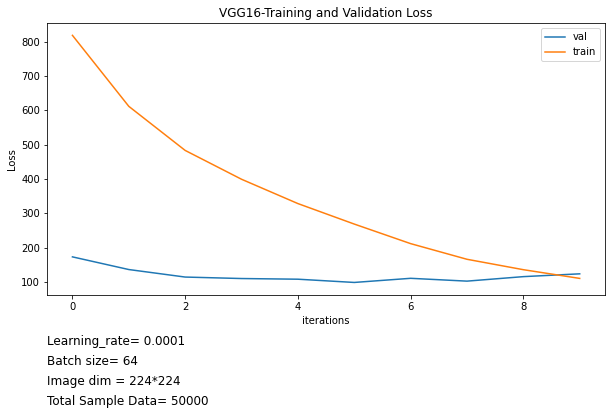

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("VGG16-Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.annotate("Learning_rate= 0.0001", (0,0), (0, -40),  fontsize=12, xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate("Batch size= "+str(BATCH_SIZE), (0,0), (0, -60),  fontsize=12, xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate("Image dim = 224*224 ", (0,0), (0, -80),  fontsize=12, xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate("Total Sample Data= 50000", (0,0), (0, -100),  fontsize=12, xycoords='axes fraction', textcoords='offset points', va='top')

plt.legend()
plt.show()

#save the model

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
model_save_name = 'cifar10_vgg16_model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

#load the saved model

In [14]:
model = VGG16_NET()
model_save_name = 'cifar10_vgg16_model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [15]:
model.cuda()
model.eval()

VGG16_NET(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3,

#test

In [29]:

with torch.no_grad():
    samples = 0
    correct = 0
    for idx, (images, labels) in enumerate(test_loader):
      #images = images.to(device = device)
      #labels = labels.to(device = device)
      images, labels = images.to(device = device), labels.to(device = device)

      outputs = model(images)
      _, preds = outputs.max(1)
     
      correct += (preds == labels).sum()
      samples += preds.size(0)

      
    print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")



accuracy 78.01 percentage || Correct 7801 out of 10000 samples


In [18]:
import pandas as pd

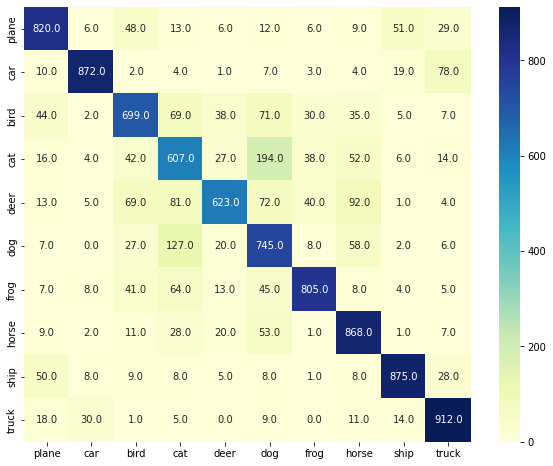

In [40]:
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        #print(len(labels))
        #print(len(predicted))
        #print("..............")
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1

_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt=".1f", cmap="YlGnBu")
plt.show()